In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from os.path import join, exists
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms

from pixyz.distributions import Normal, Bernoulli, Deterministic
from pixyz.losses import KullbackLeibler, CrossEntropy, AdversarialKullbackLeibler, AdversarialWassersteinDistance
from pixyz.models import Model

from models import *
from utils import *

batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset_zip = np.load('../data/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')
imgs = dataset_zip['imgs']
imgs = imgs[:,None,:,:].astype("float32")

train_imgs, test_imgs = train_test_split(imgs, random_state=42, test_size=1000)

transform = transforms.Compose([
    transforms.ToTensor(),
])
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=128, shuffle=True)  
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=128, shuffle=False)  

# training

1it [00:00,  6.05it/s]

Distributions (for training): 
  p(z|x), p(x|z) 
Loss function: 
  mean(-E_p(z|x)[log p(x|z)]) + mean(KL[p(z|x)||p_prior(z)]) + mean(AdversarialWD[p(z|x)||q_shuffle(z|x_)]) * 5 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.0005
      weight_decay: 0
  )


5753it [04:08, 23.15it/s]


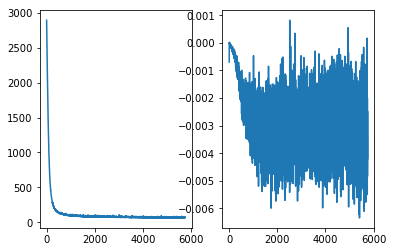

↓generate


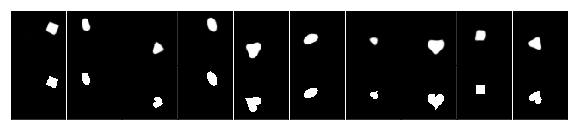

↑true


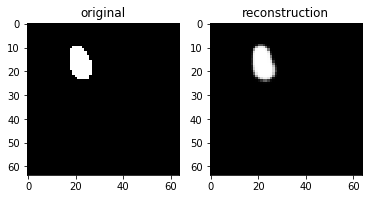

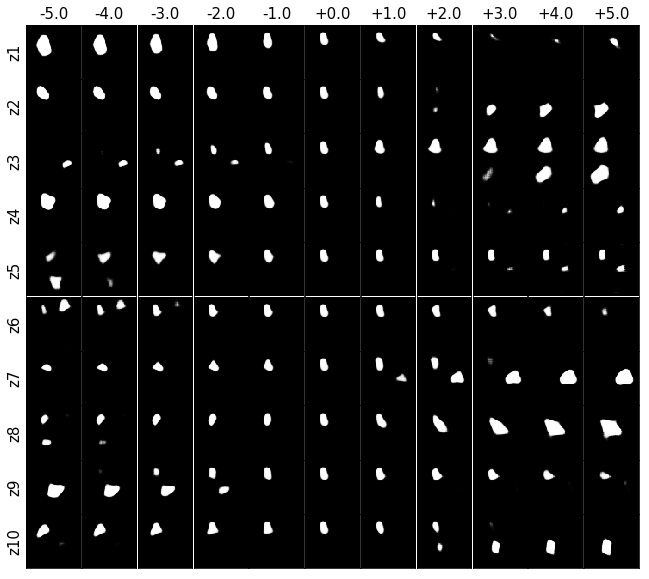

5753it [04:13, 22.72it/s]


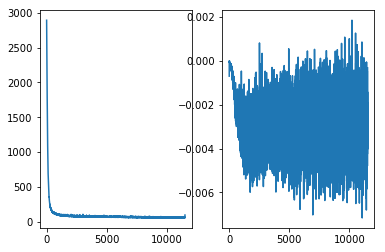

↓generate


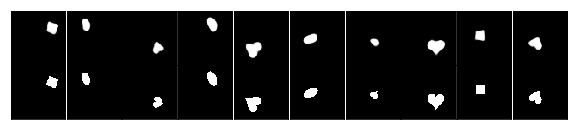

↑true


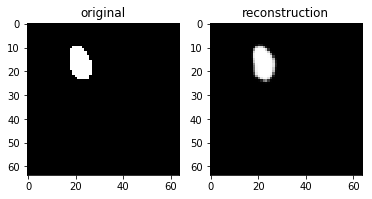

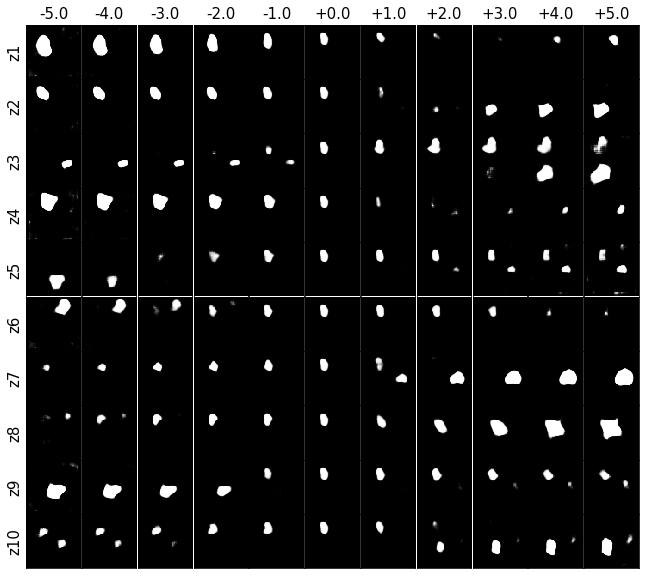

5753it [04:25, 21.67it/s]


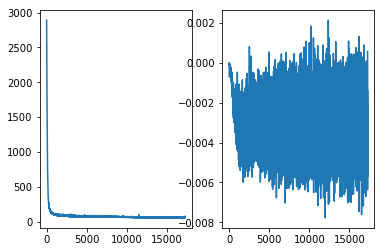

↓generate


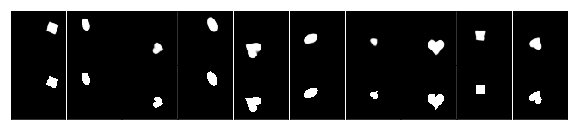

↑true


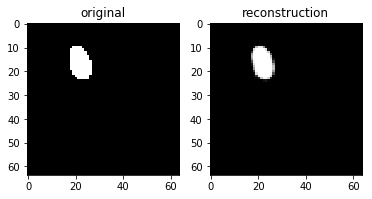

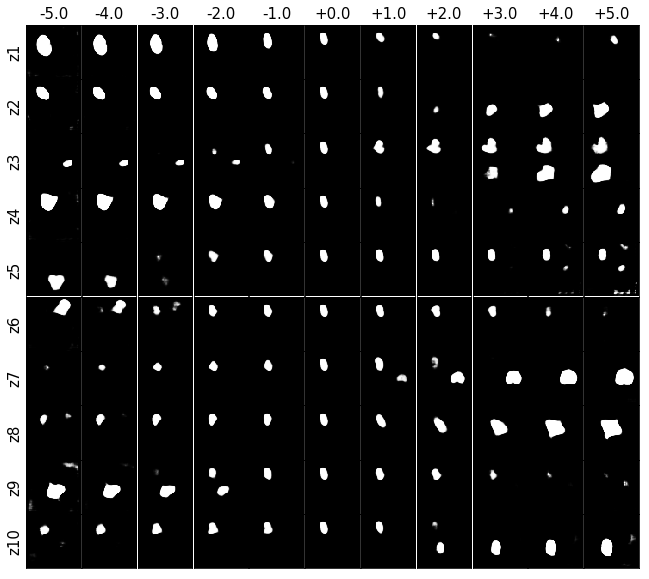

5753it [04:20, 22.05it/s]


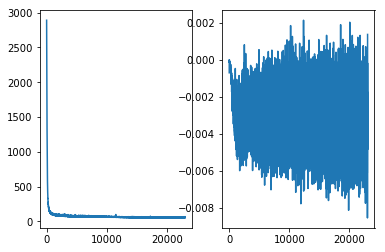

↓generate


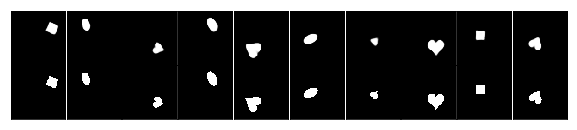

↑true


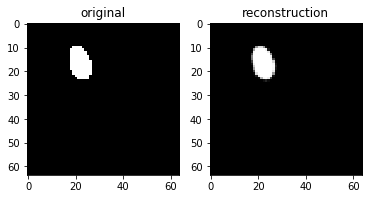

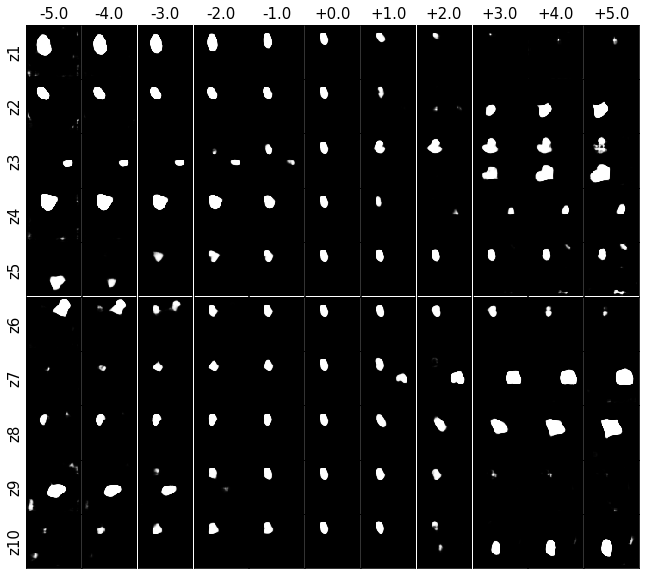

5753it [04:22, 21.90it/s]


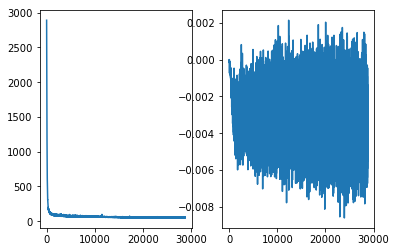

↓generate


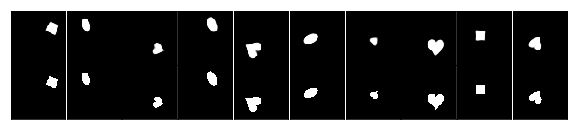

↑true


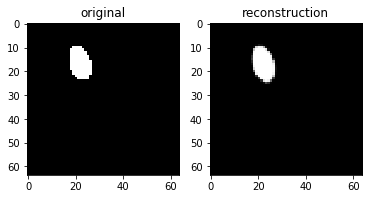

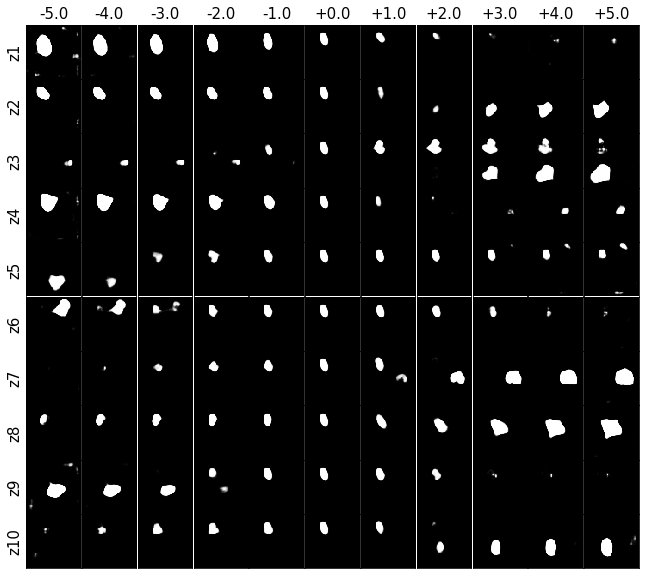

5753it [04:18, 22.24it/s]


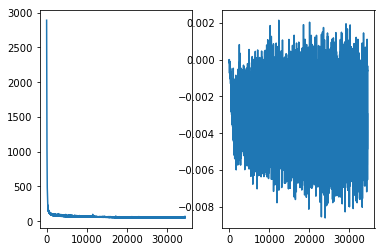

↓generate


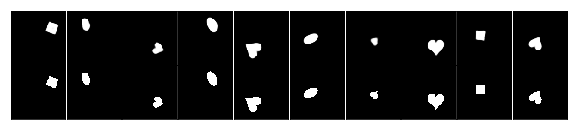

↑true


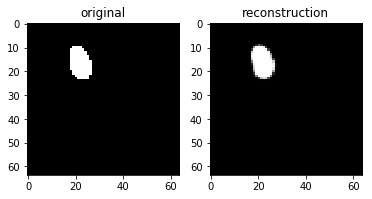

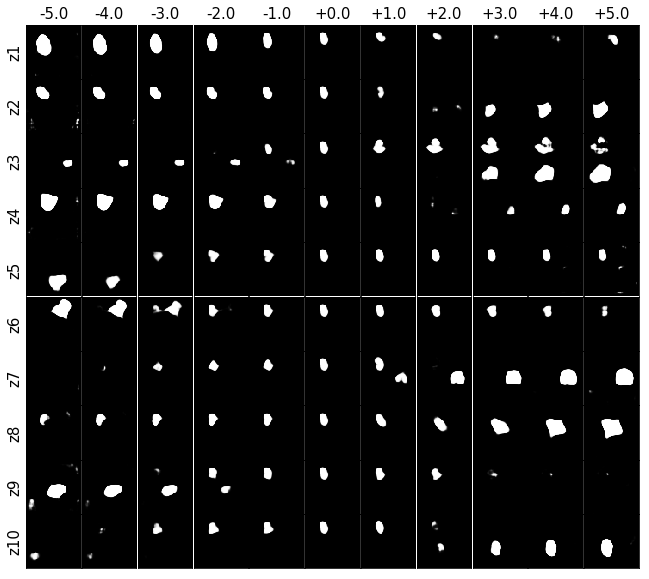

5753it [04:17, 22.30it/s]


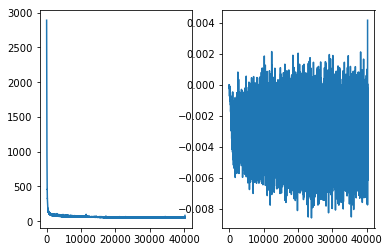

↓generate


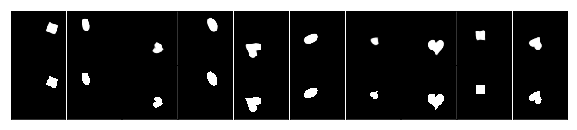

↑true


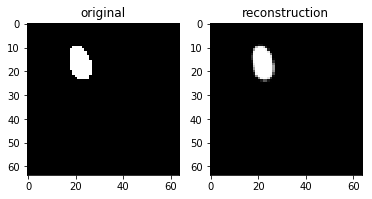

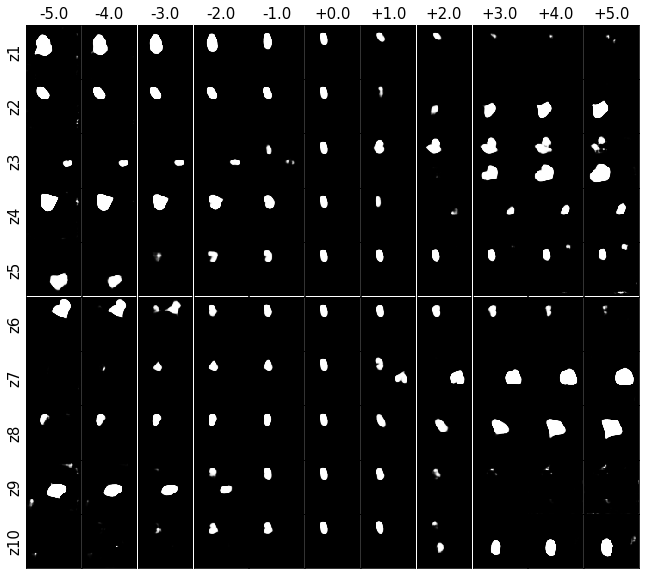

5753it [04:19, 22.19it/s]


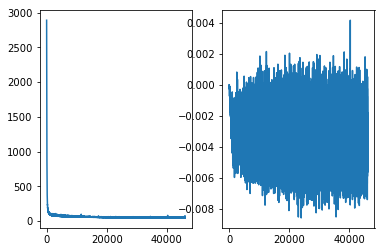

↓generate


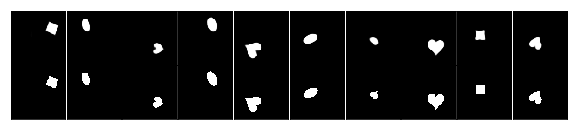

↑true


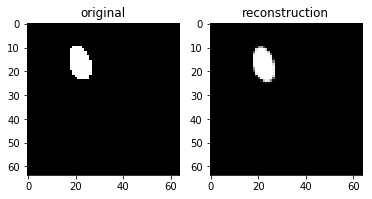

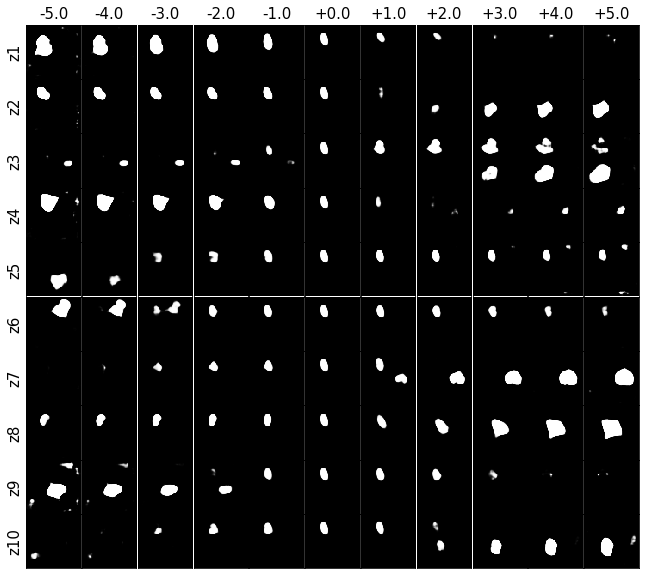

5753it [04:25, 21.69it/s]


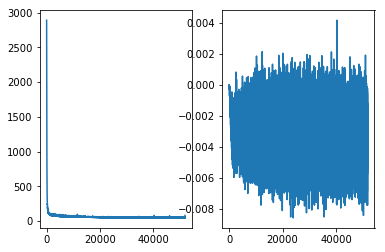

↓generate


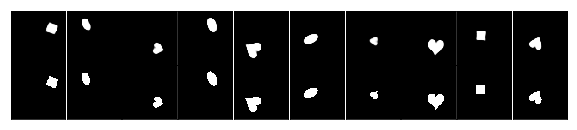

↑true


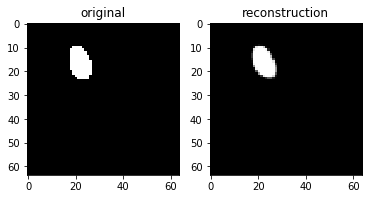

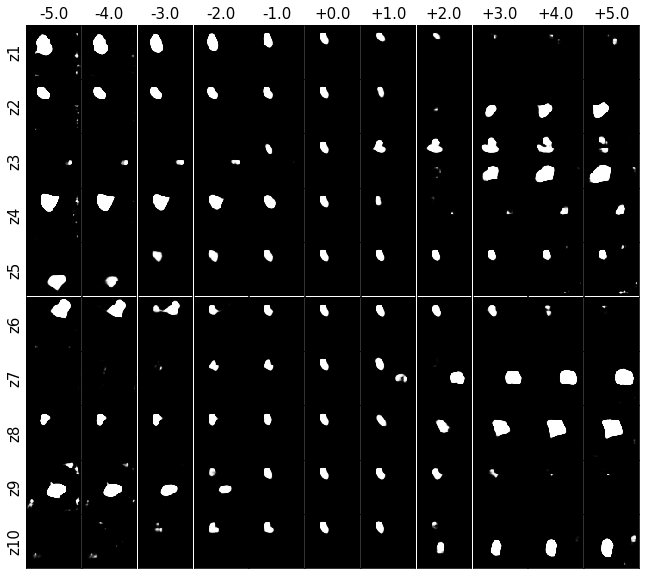

5753it [04:18, 22.25it/s]


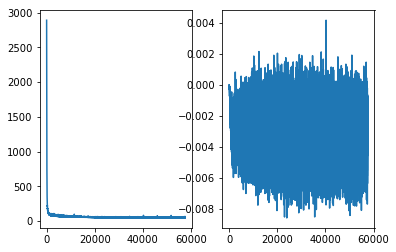

↓generate


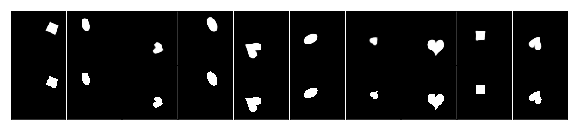

↑true


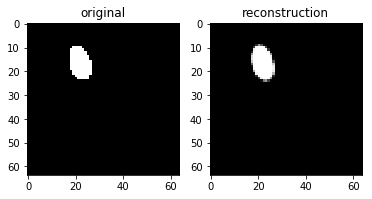

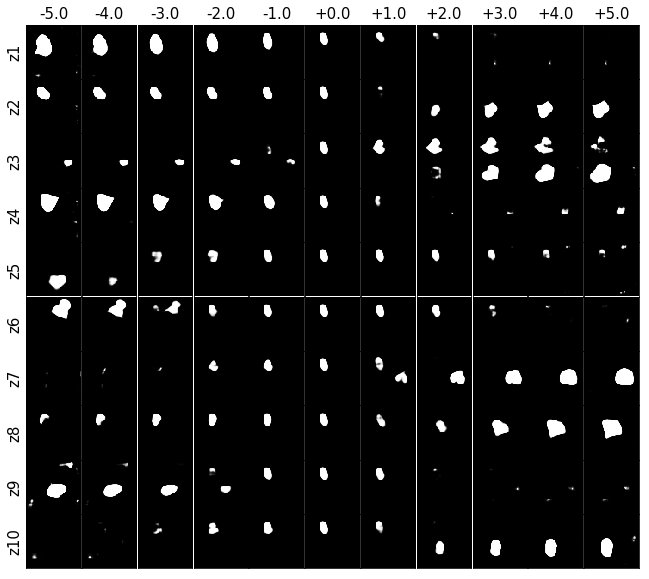

Distributions (for training): 
  p(z|x), p(x|z) 
Loss function: 
  mean(-E_p(z|x)[log p(x|z)]) + mean(KL[p(z|x)||p_prior(z)]) + mean(AdversarialWD[p(z|x)||q_shuffle(z|x_)]) * 10 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.0005
      weight_decay: 0
  )


5753it [04:20, 22.10it/s]


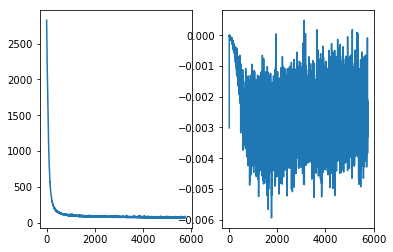

↓generate


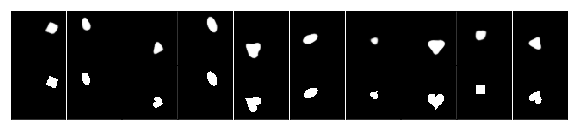

↑true


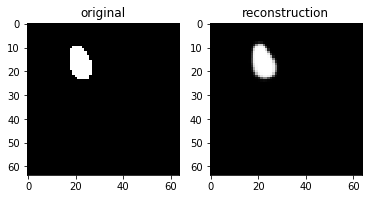

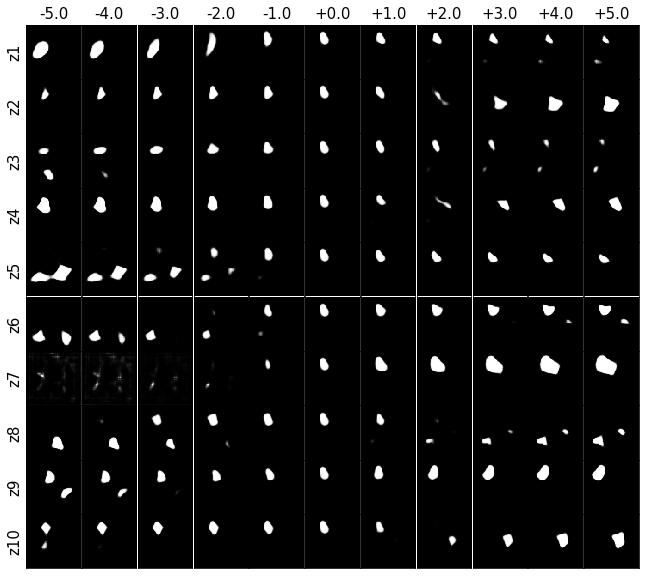

5753it [04:21, 21.97it/s]


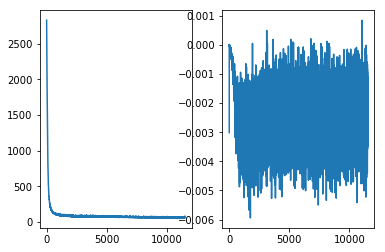

↓generate


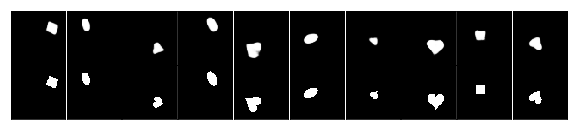

↑true


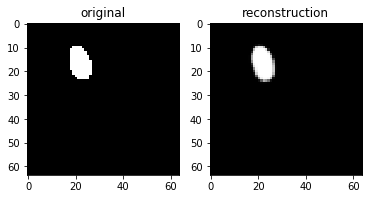

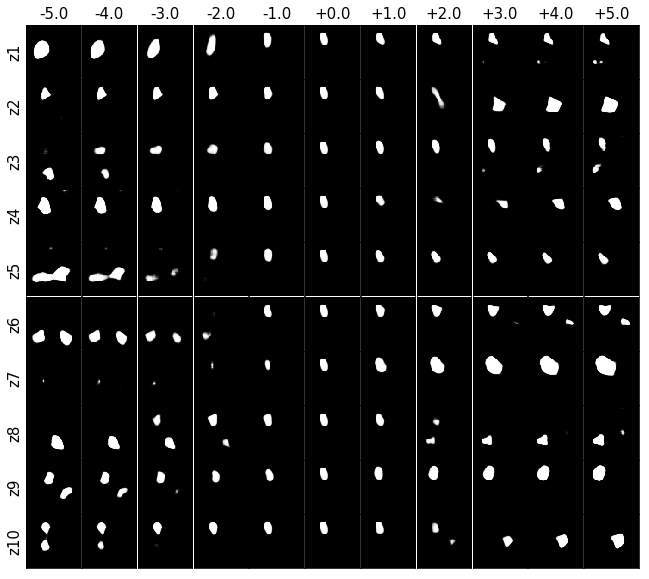

5753it [04:18, 22.23it/s]


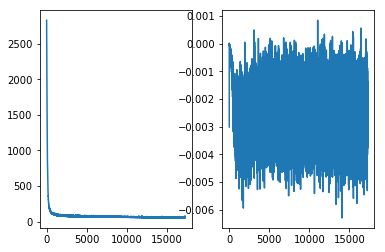

↓generate


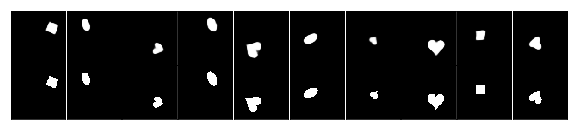

↑true


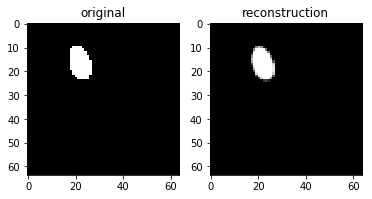

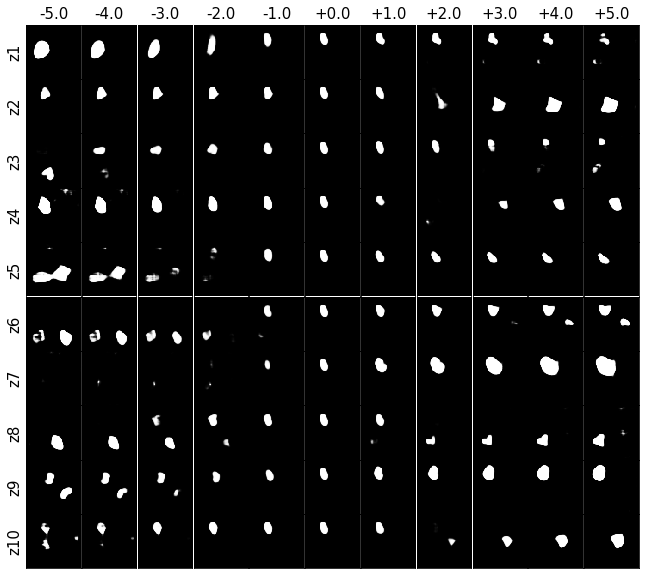

4604it [03:28, 22.08it/s]

KeyboardInterrupt: 

In [2]:
z_dim = 10
for gamma in [5, 10, 20]:
    # prior model p(z)
    loc = torch.tensor(0.).to(device)
    scale = torch.tensor(1.).to(device)
    prior = Normal(loc=loc, scale=scale, var=["z"], dim=z_dim, name="p_prior")

    E = Encoder(z_dim=z_dim).to(device) # q(z|x)
    G = Decoder(z_dim=z_dim).to(device) # p(x|z)
    D = Discriminator(z_dim=z_dim).to(device) # d(t|z)

    class InferenceShuffleDim(Deterministic):
        def __init__(self):
            super(InferenceShuffleDim, self).__init__(cond_var=["x_"], var=["z"], name="q_shuffle")

        def permute_dims(self, z):
            B, _ = z.size()
            perm_z = []
            for z_j in z.split(1, 1):
                perm = torch.randperm(B).to(z.device)
                perm_z_j = z_j[perm]
                perm_z.append(perm_z_j)

            return torch.cat(perm_z, 1)        

        def forward(self, x_):
            z = E.sample({"x": x_}, return_all=False)["z"]
            return {"z": self.permute_dims(z)}

    E_shuffle = InferenceShuffleDim()

    reconst = CrossEntropy(E, G)
    kl = KullbackLeibler(E, prior)
    tc = AdversarialWassersteinDistance(E, E_shuffle, discriminator=D, optimizer=optim.Adam, optimizer_params={"lr":1e-4})
    loss_cls = reconst.mean() + kl.mean() + gamma*tc
    model = Model(loss_cls, distributions=[E, G], optimizer=optim.Adam, optimizer_params={"lr":5e-4})
    print(model)

    loss_list = []
    loss_d_list = []
    for i in range(10):
        for batch_idx, x in tqdm(enumerate(train_loader)):
            x = x.to(device)
            loss = model.train({"x": x, "x_": x})
            loss_d = tc.train({"x": x, "x_": x})
            loss_list.append(loss.detach())
            loss_d_list.append(loss_d.detach())
        plt.subplot(121)
        plt.plot(loss_list)
        plt.subplot(122)
        plt.plot(loss_d_list)
        plt.show()
        encoder_plot(test_loader, E, G)
        traverse_plot(test_loader, E, G, 1)


    log_dir = "./logs/"
    experiment_name = "factorvae_dsprites_z_dim{}_gamma{}".format(z_dim, gamma)
    torch.save(E.state_dict(), join(log_dir, 'E_{}.pkl'.format(experiment_name)))
    torch.save(D.state_dict(), join(log_dir, 'D_{}.pkl'.format(experiment_name)))
    torch.save(G.state_dict(), join(log_dir, 'G_{}.pkl'.format(experiment_name)))

# visualize

In [ ]:
z_dim=10
gamma = 10
log_dir = "./logs/"
experiment_name = "factorvae_dsprites_z_dim{}_gamma{}".format(z_dim, gamma)
E = Encoder(z_dim=z_dim).to(device) # q(z|x)
G = Decoder(z_dim=z_dim).to(device) # p(x|z)
E.load_state_dict(torch.load(join(log_dir, 'E_{}.pkl'.format(experiment_name))))
G.load_state_dict(torch.load(join(log_dir, 'G_{}.pkl'.format(experiment_name))))

In [ ]:
traverse_plot(test_loader, E, G, 1)

In [ ]:
make_gif(0, test_loader, E, G, experiment_name, m=30, scale=3, z_dim=10)
make_gif(1, test_loader, E, G, experiment_name, m=30, scale=3, z_dim=10)
make_gif(2, test_loader, E, G, experiment_name, m=30, scale=3, z_dim=10)

In [ ]:
from imp import reload
import models
import utils
from models import *
from utils import *